# 1. Importação das bibliotecas, definição dos métodos e tratamento inicial




In [86]:
%%capture
!pip install ray
!pip install unicode
!pip install unidecode
!pip install boruta
!pip install catboost
!pip install openpyxl

In [ ]:
%%capture
!pip install xgboost
!pip install lightgbm

In [1]:
%run BorutaShap.ipynb

In [2]:
import pandas as pd
import ray
import plotly.express as px
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import numpy as np
import unidecode
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
def find_best_lambda(data, lambda_range):
    best_lambda = None
    best_llf = -np.inf  # initialize with negative infinity

    for lmbda in lambda_range:
        llf = stats.yeojohnson_llf(lmbda, data)
        if llf > best_llf:
            best_llf = llf
            best_lambda = lmbda

    return best_lambda

In [4]:
def remove_accents(a):
  a = a.encode('utf-8', errors='ignore')
  return unidecode.unidecode(a.decode('utf-8'))

In [5]:
cadunico = pd.read_csv("data/cadunico_data_brazil.csv")
sisvan = pd.read_excel("data/altura_idade.xlsx")

In [6]:
sisvan

,ALTURA X IDADE,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Região,Código UF,UF,Código IBGE,Município,Altura Muito Baixa\npara a Idade,NaN,Altura Baixa\npara a Idade,NaN,Altura Adequada\npara a Idade,NaN,Total
1,NaN,NaN,NaN,NaN,NaN,Quantidade,%,Quantidade,%,Quantidade,%,NaN
2,CENTRO-OESTE,53,DF,530010,BRASILIA,2344,3.06%,4438,5.79%,69802,91.14%,76584
3,TOTAL ESTADO DISTRITO FEDERAL,NaN,NaN,NaN,NaN,2344,3.06%,4438,5.79%,69802,91.14%,76584
4,CENTRO-OESTE,52,GO,520005,ABADIA DE GOIAS,15,4.36%,16,4.65%,313,90.99%,344
...,...,...,...,...,...,...,...,...,...,...,...,...
5604,TOTAL BRASIL,NaN,NaN,NaN,NaN,311693,4.74%,427905,6.5%,5841819,88.76%,6581417
5605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5607,VersÃ£o 3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
sisvan.loc[0, sisvan.columns[6]] = 'Altura Muito Baixa\npara a Idade (%)'
sisvan.loc[0, sisvan.columns[8]] = 'Altura Baixa\npara a Idade (%)'
sisvan.loc[0, sisvan.columns[10]] = 'Altura Adequada\npara a Idade (%)'
sisvan.dropna(inplace=True)

sisvan.columns = sisvan.iloc[0]
sisvan = sisvan[1:].copy()
sisvan.reset_index(drop=True, inplace=True)

for i, val in enumerate(sisvan['Município']):
  val += ' - '
  val += sisvan.loc[i, 'UF']
  sisvan.loc[i, 'Município'] = val

sisvan = sisvan.iloc[:, [4, 6, 8]].copy()

sisvan.replace(['%'], [''], regex=True, inplace=True)
sisvan['Município'] = sisvan['Município'].apply(remove_accents)

for col in sisvan.columns[1:]:
  sisvan[col]= sisvan[col].replace(['-'], [0], regex=True)
  sisvan[col] = sisvan[col].astype(float)

sisvan['Município'] = sisvan['Município'].str.lower()

sisvan['Peso/Altura < Escore-z -2 (%)'] = sisvan[sisvan.columns[1]] + sisvan[sisvan.columns[2]]
sisvan.drop(columns=sisvan.columns[1:3], inplace=True)

In [8]:
cadunico['Município'] = cadunico['Município'].str.lower()
cadunico['Município'] = cadunico['Município'].apply(remove_accents)

In [9]:
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', None)
cadunico

,Município,Estado cadastral da família / Sem Registro Civil,Estado cadastral da família / Cadastrado,Faixa da renda total da família / Até 1 S.M.,Faixa da renda total da família / Entre 1 e 2 S.M.,Faixa da renda total da família / Entre 2 e 3 S.M.,Faixa da renda total da família / Acima de 3 S.M.,Faixa da renda familiar per capita / Pobreza 1 (até R$ 109),Faixa da renda familiar per capita / Pobreza 2 (de R$ 109 a R$ 218),Faixa da renda familiar per capita / Baixa Renda,Faixa da renda familiar per capita / Acima de 1/2 S.M.,Forma de coleta / Informação migrada como inexistente,Forma de coleta / Sem visita Domiciliar,Forma de coleta / Com visita domiciliar,Número de meses após a última atualização cadastral / até 12 Meses,Número de meses após a última atualização cadastral / 13 a 18 Meses,Número de meses após a última atualização cadastral / 19 a 24 Meses,Número de meses após a última atualização cadastral / 25 a 36 Meses,Número de meses após a última atualização cadastral / 37 a 48 Meses,Número de meses após a última atualização cadastral / acima de 48 Meses,Recebe PBF família / Não,Recebe PBF família / Sim,Calçamento em frente ao seu domicílio / Total,Calçamento em frente ao seu domicílio / Parcial,Calçamento em frente ao seu domicílio / Não existe,Situação do domicílio / Urbanas,Situação do domicílio / Rurais,Espécie do domicílio / Particular Permanente,Espécie do domicílio / Particular improvisado,Espécie do domicílio / Coletivo,Existência de banheiro / Sim,Existência de banheiro / Não,Forma de abastecimento de água / Rede geral de distribuição,Forma de abastecimento de água / Poço ou nascente,Forma de abastecimento de água / Cisterna,Forma de abastecimento de água / Outra forma,Forma de coleta do lixo / É coletado diretamente,Forma de coleta do lixo / É coletado indiretamente,Forma de coleta do lixo / É queimado ou enterrado na propriedade,"Forma de coleta do lixo / É jogado em terreno baldio ou logradouro (rua, avenida, etc.)",Forma de coleta do lixo / É jogado em rio ou mar,Forma de coleta do lixo / Tem outro destino,Forma de escoamento sanitário / Rede coletora de esgoto ou pluvial,Forma de escoamento sanitário / Fossa séptica,Forma de escoamento sanitário / Fossa rudimentar,Forma de escoamento sanitário / Vala a céu aberto,"Forma de escoamento sanitário / Direto para um rio, lago ou mar",Forma de escoamento sanitário / Outra forma,Material predominante nas paredes externas do domicílio / Alvenaria/tijolo com revestimento,Material predominante nas paredes externas do domicílio / Alvenaria/tijolo sem revestimento,Material predominante nas paredes externas do domicílio / Madeira aparelhada,Material predominante nas paredes externas do domicílio / Taipa revestida,Material predominante nas paredes externas do domicílio / Taipa não revestida,Material predominante nas paredes externas do domicílio / Madeira aproveitada,Material predominante nas paredes externas do domicílio / Palha,Material predominante nas paredes externas do domicílio / Outro Material,Material predominante no piso do domicílio / Terra,Material predominante no piso do domicílio / Cimento,Material predominante no piso do domicílio / Madeira aproveitada,Material predominante no piso do domicílio / Madeira aparelhada,"Material predominante no piso do domicílio / Cerâmica, lajota ou pedra",Material predominante no piso do domicílio / Carpete,Material predominante no piso do domicílio / Outro Material,Água canalizada no domicílio / Sim,Água canalizada no domicílio / Não,Tipo de iluminação / Elétrica com medidor próprio,Tipo de iluminação / Elétrica com medidor comunitário,Tipo de iluminação / Elétrica sem medidor,"Tipo de iluminação / Óleo, querosene ou gás",Tipo de iluminação / Vela,Tipo de iluminação / Outra forma,Família Indígena / Sim,Família Indígena / Não,Família quilombola / Sim,Família quilombola / Não,Cor ou raça / Branca,Cor ou raça / Preta,Cor ou raça / Amarela,Cor ou raça / Parda,Cor ou raça / Indígena,Estado cadastral da pessoa / Sem Registro Civil,E

In [10]:
df = sisvan.join(cadunico.set_index('Município'), on='Município')
df = df.dropna()

In [11]:
mask = df['Município'].str.contains(' - ce')
df_test = df[mask]
df_train = df[~mask]

In [12]:
 # df_train, df_test = train_test_split(df, test_size=0.25)

In [13]:
df_test

,Município,Peso/Altura < Escore-z -2 (%),Estado cadastral da família / Sem Registro Civil,Estado cadastral da família / Cadastrado,Faixa da renda total da família / Até 1 S.M.,Faixa da renda total da família / Entre 1 e 2 S.M.,Faixa da renda total da família / Entre 2 e 3 S.M.,Faixa da renda total da família / Acima de 3 S.M.,Faixa da renda familiar per capita / Pobreza 1 (até R$ 109),Faixa da renda familiar per capita / Pobreza 2 (de R$ 109 a R$ 218),Faixa da renda familiar per capita / Baixa Renda,Faixa da renda familiar per capita / Acima de 1/2 S.M.,Forma de coleta / Informação migrada como inexistente,Forma de coleta / Sem visita Domiciliar,Forma de coleta / Com visita domiciliar,Número de meses após a última atualização cadastral / até 12 Meses,Número de meses após a última atualização cadastral / 13 a 18 Meses,Número de meses após a última atualização cadastral / 19 a 24 Meses,Número de meses após a última atualização cadastral / 25 a 36 Meses,Número de meses após a última atualização cadastral / 37 a 48 Meses,Número de meses após a última atualização cadastral / acima de 48 Meses,Recebe PBF família / Não,Recebe PBF família / Sim,Calçamento em frente ao seu domicílio / Total,Calçamento em frente ao seu domicílio / Parcial,Calçamento em frente ao seu domicílio / Não existe,Situação do domicílio / Urbanas,Situação do domicílio / Rurais,Espécie do domicílio / Particular Permanente,Espécie do domicílio / Particular improvisado,Espécie do domicílio / Coletivo,Existência de banheiro / Sim,Existência de banheiro / Não,Forma de abastecimento de água / Rede geral de distribuição,Forma de abastecimento de água / Poço ou nascente,Forma de abastecimento de água / Cisterna,Forma de abastecimento de água / Outra forma,Forma de coleta do lixo / É coletado diretamente,Forma de coleta do lixo / É coletado indiretamente,Forma de coleta do lixo / É queimado ou enterrado na propriedade,"Forma de coleta do lixo / É jogado em terreno baldio ou logradouro (rua, avenida, etc.)",Forma de coleta do lixo / É jogado em rio ou mar,Forma de coleta do lixo / Tem outro destino,Forma de escoamento sanitário / Rede coletora de esgoto ou pluvial,Forma de escoamento sanitário / Fossa séptica,Forma de escoamento sanitário / Fossa rudimentar,Forma de escoamento sanitário / Vala a céu aberto,"Forma de escoamento sanitário / Direto para um rio, lago ou mar",Forma de escoamento sanitário / Outra forma,Material predominante nas paredes externas do domicílio / Alvenaria/tijolo com revestimento,Material predominante nas paredes externas do domicílio / Alvenaria/tijolo sem revestimento,Material predominante nas paredes externas do domicílio / Madeira aparelhada,Material predominante nas paredes externas do domicílio / Taipa revestida,Material predominante nas paredes externas do domicílio / Taipa não revestida,Material predominante nas paredes externas do domicílio / Madeira aproveitada,Material predominante nas paredes externas do domicílio / Palha,Material predominante nas paredes externas do domicílio / Outro Material,Material predominante no piso do domicílio / Terra,Material predominante no piso do domicílio / Cimento,Material predominante no piso do domicílio / Madeira aproveitada,Material predominante no piso do domicílio / Madeira aparelhada,"Material predominante no piso do domicílio / Cerâmica, lajota ou pedra",Material predominante no piso do domicílio / Carpete,Material predominante no piso do domicílio / Outro Material,Água canalizada no domicílio / Sim,Água canalizada no domicílio / Não,Tipo de iluminação / Elétrica com medidor próprio,Tipo de iluminação / Elétrica com medidor comunitário,Tipo de iluminação / Elétrica sem medidor,"Tipo de iluminação / Óleo, querosene ou gás",Tipo de iluminação / Vela,Tipo de iluminação / Outra forma,Família Indígena / Sim,Família Indígena / Não,Família quilombola / Sim,Família quilombola / Não,Cor ou raça / Branca,Cor ou raça / Preta,Cor ou raça / Amarela,Cor ou raça / Parda,Cor ou raça / Indígena,Estado cadastral da

In [14]:
x_train = df_train.drop(columns=df_train.columns[0:2])
y_train = df_train[df_train.columns[1]]

x_test = df_test.drop(columns=df_test.columns[0:2])
y_test = df_test[df_test.columns[1]]

# 2. Teste dos algoritmos

In [15]:
import catboost as cb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## 2.1 Random Forest

In [16]:
forest = RandomForestRegressor(
   n_jobs = -1, max_depth = 7, n_estimators=200
)

Feature_Selector = BorutaShap(model=forest,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_train, y=y_train, n_trials=100, random_state=0, verbose=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
rf_accepted = Feature_Selector.Subset(tentative=True).columns
print(rf_accepted)
print(len(rf_accepted))

Index(['Recebe PBF família / Não.1',
       'Material predominante nas paredes externas do domicílio / Alvenaria/tijolo sem revestimento',
       'Grupos Populacionais Tradicionais e Específicos / Familia Extrativista',
       'Faixa etária / Entre 60 a 64', 'Recebe PBF família / Sim',
       'Faixa etária / Entre 7 a 15',
       'Material predominante no piso do domicílio / Terra',
       'Recebe PBF família / Sim.1', 'Cor ou raça / Parda',
       'Faixa etária / Entre 55 a 59', 'Faixa etária / Entre 16 a 17',
       'A pessoa concluiu o curso? / Não',
       'Último ano e série do curso que a pessoa frequentou / Quinto(a)',
       'Faixa da renda total da família / Acima de 3 S.M.',
       'Faixa etária / Entre 45 a 49', 'Água canalizada no domicílio / Não',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental (duração 9 anos)',
       'Cor ou raça / Branca', 'Faixa etária / Entre 0 e 4',
       'Relação de parentesco com o responsável familiar / Cônjuge ou companh

In [18]:
x_tr = x_train[rf_accepted]

In [19]:
grid = {'max_depth': [5, 8, 10],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 25, 50, 70],
        'max_features': ['log2', 0.25, 'sqrt', 1.0]}

clf = GridSearchCV(RandomForestRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_train)
clf.best_params_

{'max_depth': 10,
 'max_features': 1.0,
 'min_samples_leaf': 25,
 'min_samples_split': 10}

In [20]:
forest = RandomForestRegressor(n_estimators=200, max_depth=clf.best_params_['max_depth'],
    max_features = clf.best_params_['max_features'], min_samples_leaf = clf.best_params_['min_samples_leaf'], 
    min_samples_split = clf.best_params_['min_samples_split']
)

scores = cross_validate(forest, x_tr, y_train, cv=10,
                               scoring='neg_root_mean_squared_error')

rmse = np.mean(scores['test_score']*(-1))
std = np.std(scores['test_score']*(-1))

print(rmse)
print(std)

4.880006336815482
0.5312433994718158


## 2.2 Gradient Boosting

In [21]:
gb = GradientBoostingRegressor(
   max_depth = 7, n_estimators=200
)

Feature_Selector = BorutaShap(model=gb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_train, y=y_train, n_trials=100, random_state=0, verbose=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
gb_accepted = Feature_Selector.Subset(tentative=True).columns
print(gb_accepted)
print(len(gb_accepted))

Index(['Material predominante nas paredes externas do domicílio / Alvenaria/tijolo sem revestimento',
       'Faixa etária / Entre 55 a 59',
       'Curso mais elevado que a pessoa frequentou / Ensino Médio, 2º grau, Médio 2º ciclo (Científico, Clássico, Técnico, Normal)',
       'Material predominante no piso do domicílio / Terra',
       'Faixa etária / Entre 35 a 39',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental (duração 9 anos)',
       'Água canalizada no domicílio / Não',
       'Função principal / Militar ou servidor público',
       'Faixa etária / Entre 60 a 64', 'Faixa etária / Entre 7 a 15',
       'Cor ou raça / Branca',
       'Função principal / Empregado sem carteira de trabalho assinada',
       'Curso que a pessoa frequenta / Ensino Fundamental regular (duração 9 anos)',
       'Relação de parentesco com o responsável familiar / Cônjuge ou companheiro(a)',
       'Faixa etária / Entre 18 a 24',
       'Ano e série do curso que a pessoa freque

In [23]:
x_tr = x_train[gb_accepted]

In [24]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10],
        'max_features': ['log2', 0.25, 'sqrt', 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(GradientBoostingRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_train)
clf.best_params_

{'learning_rate': 0.025,
 'max_depth': 3,
 'max_features': 0.25,
 'subsample': 1.0}

In [25]:
gb = GradientBoostingRegressor(n_estimators=200,learning_rate=clf.best_params_['learning_rate'],
                               max_depth=clf.best_params_['max_depth'],max_features=clf.best_params_['max_features'],
                               subsample=clf.best_params_['subsample']
)

scores = cross_validate(gb, x_tr, y_train, cv=10,
                               scoring='neg_root_mean_squared_error')

rmse = np.mean(scores['test_score']*(-1))
std = np.std(scores['test_score']*(-1))

print(rmse)
print(std)

4.899820929777251
0.5256205092835418


## 2.3 Catboost

In [17]:
ctb = CatBoostRegressor(iterations=200, task_type="GPU")

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=ctb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_train, y=y_train, n_trials=100, random_state=0, verbose=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
ctb_accepted = Feature_Selector.Subset(tentative=True).columns
print(ctb_accepted)
print(len(ctb_accepted))

Index(['Ano e série do curso que a pessoa frequenta / Segundo(a)',
       'Curso que a pessoa frequenta / Ensino Fundamental regular (duração 9 anos)',
       'Tipo de iluminação / Elétrica com medidor próprio',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental EJA -séries iniciais (Supletivo 1ª a 4ª)',
       'Faixa etária / Entre 35 a 39',
       'Função principal / Militar ou servidor público',
       'Forma de escoamento sanitário / Vala a céu aberto',
       'Função principal / Empregado sem carteira de trabalho assinada',
       'Faixa da renda familiar per capita / Acima de 1/2 S.M.',
       'Relação de parentesco com o responsável familiar / Pessoa Responsável pela Unidade Familiar - RF',
       'Cor ou raça / Branca',
       'Material predominante no piso do domicílio / Terra',
       'Último ano e série do curso que a pessoa frequentou / Sexto(a)',
       'Faixa etária / Entre 18 a 24',
       'Recebe ajuda de outra forma / Opção marcada no formulário',


In [19]:
x_tr = x_train[ctb_accepted]

In [20]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 6, 9],
        'leaf_estimation_iterations': [1, 10],
        'l2_leaf_reg': [1, 3, 6, 9]}

clf = GridSearchCV(CatBoostRegressor(iterations=200, task_type="GPU", verbose=0), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_train)
clf.best_params_

{'l2_leaf_reg': 9,
 'leaf_estimation_iterations': 1,
 'learning_rate': 0.05,
 'max_depth': 6}

In [21]:
ctb = CatBoostRegressor(n_estimators=200, verbose=0, l2_leaf_reg=clf.best_params_['l2_leaf_reg'],
                        leaf_estimation_iterations=clf.best_params_['leaf_estimation_iterations'],
                        learning_rate=clf.best_params_['learning_rate'], max_depth=clf.best_params_['max_depth']
)

scores = cross_validate(ctb, x_tr, y_train, cv=10,
                               scoring='neg_root_mean_squared_error')

rmse = np.mean(scores['test_score']*(-1))
std = np.std(scores['test_score']*(-1))

print(rmse)
print(std)

4.888485325355599
0.5104000640301797


## 2.4 XGBoost

In [22]:
xgb = XGBRegressor(n_estimators=200, tree_method ="gpu_hist", predictor="gpu_predictor")

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=xgb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_train, y=y_train, n_trials=100, random_state=0, verbose=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
xgb_accepted = Feature_Selector.Subset(tentative=True).columns
print(xgb_accepted)
print(len(xgb_accepted))

Index(['Faixa etária / Entre 35 a 39',
       'Curso que a pessoa frequenta / Ensino Fundamental regular (duração 9 anos)',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental (duração 9 anos)',
       'Faixa etária / Entre 0 e 4',
       'Função principal / Militar ou servidor público',
       'Faixa etária / Entre 7 a 15', 'Faixa etária / Entre 55 a 59',
       'Curso mais elevado que a pessoa frequentou / Ensino Médio, 2º grau, Médio 2º ciclo (Científico, Clássico, Técnico, Normal)',
       'Cor ou raça / Branca',
       'Função principal / Empregado sem carteira de trabalho assinada',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental EJA -séries iniciais (Supletivo 1ª a 4ª)',
       'Material predominante no piso do domicílio / Terra',
       'Água canalizada no domicílio / Não',
       'Faixa da renda total da família / Até 1 S.M.',
       'Faixa etária / Entre 18 a 24',
       'Relação de parentesco com o responsável familiar / Pessoa Res

In [24]:
x_tr = x_train[xgb_accepted]

In [25]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10, 100],
        'colsample_bylevel': ['log2', 'sqrt', 0.25, 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(XGBRegressor(n_estimators=200, tree_method="gpu_hist", predictor="gpu_predictor"), 
                   grid, cv = 10, scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_train)
clf.best_params_

{'colsample_bylevel': 0.25,
 'learning_rate': 0.025,
 'max_depth': 3,
 'subsample': 0.75}

In [26]:
xgb = XGBRegressor(n_estimators=200,colsample_bylevel=clf.best_params_['colsample_bylevel'],
                   learning_rate=clf.best_params_['learning_rate'], max_depth=clf.best_params_['max_depth'],
                   subsample=clf.best_params_['subsample']
)

scores = cross_validate(xgb, x_tr, y_train, cv=10,
                               scoring='neg_root_mean_squared_error')

rmse = np.mean(scores['test_score']*(-1))
std = np.std(scores['test_score']*(-1))

print(rmse)
print(std)

4.874595638606548
0.529933452424555


## 2.5 LightGBM

In [27]:
x_train_lgb = x_train.copy()
y_train_lgb = y_train.copy()

x_train_lgb.columns = [str(i) for i in list(range(len(x_train_lgb.columns)))]
y_train_lgb.columns = ['target']

In [ ]:
lgb = LGBMRegressor(n_estimators=200)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=lgb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_train_lgb, y=y_train_lgb, n_trials=100, random_state=0)

In [35]:
lgb_accepted = Feature_Selector.Subset(tentative=True).columns
print(lgb_accepted)
print(len(lgb_accepted))

Index(['144', '162', '87', '20', '63', '55', '89', '201', '154', '93', '160',
       '215', '174', '83', '2', '210', '74', '45', '85', '48', '92', '122',
       '164', '98'],
      dtype='object')
24


In [30]:
x_tr = x_train_lgb[lgb_accepted]

In [31]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'num_leaves': [3, 7, 15, 31, 127, 1024],
        'top_rate': [0.2, 0.4, 0.6, 0.7],
        'other_rate': [0.05, 0.1, 0.3],
        'feature_fraction_bynode': [0.25, 1.0]}

# Setting verbose=-1 in LGBMRegressor to suppress warnings
clf = GridSearchCV(LGBMRegressor(n_estimators=200, verbose=-1), grid, cv=10,
                   scoring='neg_root_mean_squared_error', verbose=0)

clf.fit(x_tr, y_train_lgb)
clf.best_params_

{'feature_fraction_bynode': 0.25,
 'learning_rate': 0.025,
 'num_leaves': 15,
 'other_rate': 0.05,
 'top_rate': 0.2}

In [32]:
lgb = LGBMRegressor(n_estimators=200, feature_fraction_bynode=clf.best_params_['feature_fraction_bynode'],
                    learning_rate=clf.best_params_['learning_rate'], num_leaves=clf.best_params_['num_leaves'],
                    other_rate=clf.best_params_['other_rate'], top_rate=clf.best_params_['top_rate']
)

scores = cross_validate(lgb, x_tr, y_train_lgb, cv=10,
                               scoring='neg_root_mean_squared_error')

rmse = np.mean(scores['test_score']*(-1))
std = np.std(scores['test_score']*(-1))

print(rmse)
print(std)

4.888218764957587
0.5250872695452321


# 3. Obtensão da correlação

In [28]:
xgb_accepted = ['Faixa etária / Entre 35 a 39',
       'Curso que a pessoa frequenta / Ensino Fundamental regular (duração 9 anos)',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental (duração 9 anos)',
       'Faixa etária / Entre 0 e 4',
       'Função principal / Militar ou servidor público',
       'Faixa etária / Entre 7 a 15', 'Faixa etária / Entre 55 a 59',
       'Curso mais elevado que a pessoa frequentou / Ensino Médio, 2º grau, Médio 2º ciclo (Científico, Clássico, Técnico, Normal)',
       'Cor ou raça / Branca',
       'Função principal / Empregado sem carteira de trabalho assinada',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental EJA -séries iniciais (Supletivo 1ª a 4ª)',
       'Material predominante no piso do domicílio / Terra',
       'Água canalizada no domicílio / Não',
       'Faixa da renda total da família / Até 1 S.M.',
       'Faixa etária / Entre 18 a 24',
       'Relação de parentesco com o responsável familiar / Pessoa Responsável pela Unidade Familiar - RF',
       'Relação de parentesco com o responsável familiar / Cônjuge ou companheiro(a)',
       'Recebe PBF família / Sim']

In [29]:
x_train = x_train[xgb_accepted]
x_test = x_test[xgb_accepted]

In [39]:
def histogram_plot(mtx, width=2000, height=600):
  fig = px.imshow(mtx[:][-1:],
                #x=cadunico_data.columns,
                #y=cadunico_data.columns,
                text_auto=True,
                color_continuous_scale='Inferno',
                width=width, height=height
               )

  fig.update_layout(
      margin=dict(l=0, r=0, t=0, b=0),
      autosize=True,
      #xaxis_nticks=len(cadunico_data.columns),
      #yaxis_nticks=len(cadunico_data.columns)
      )

  fig.show()

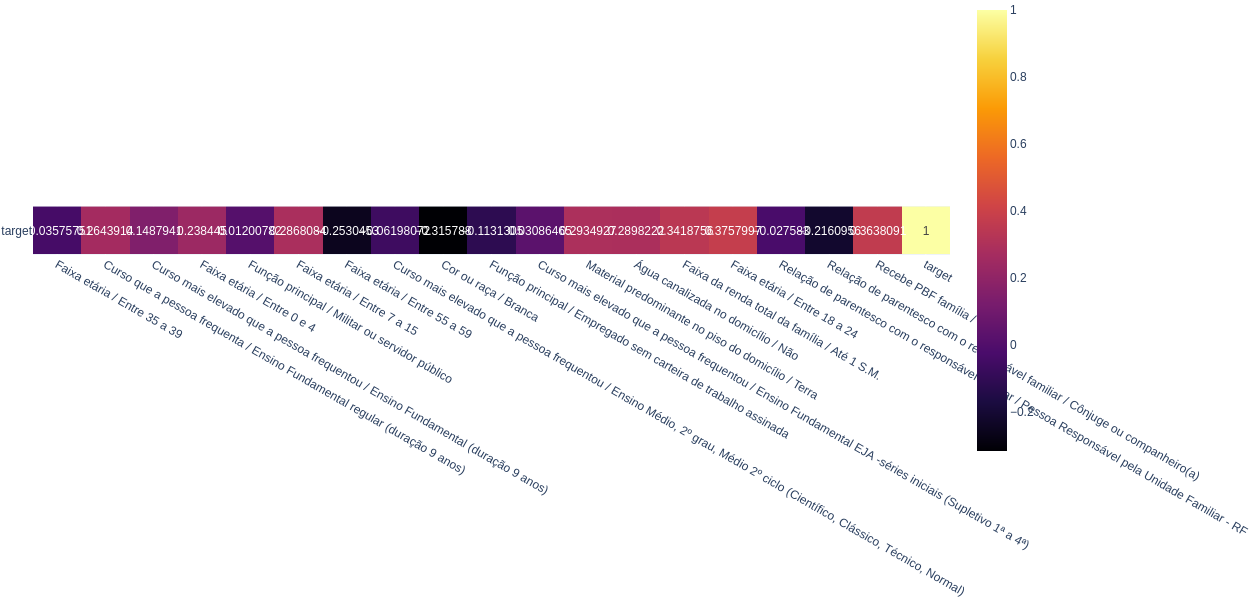

In [41]:
data = x_train.copy()
data['target'] = y_train
corr_matrix = data.corr()
histogram_plot(corr_matrix)

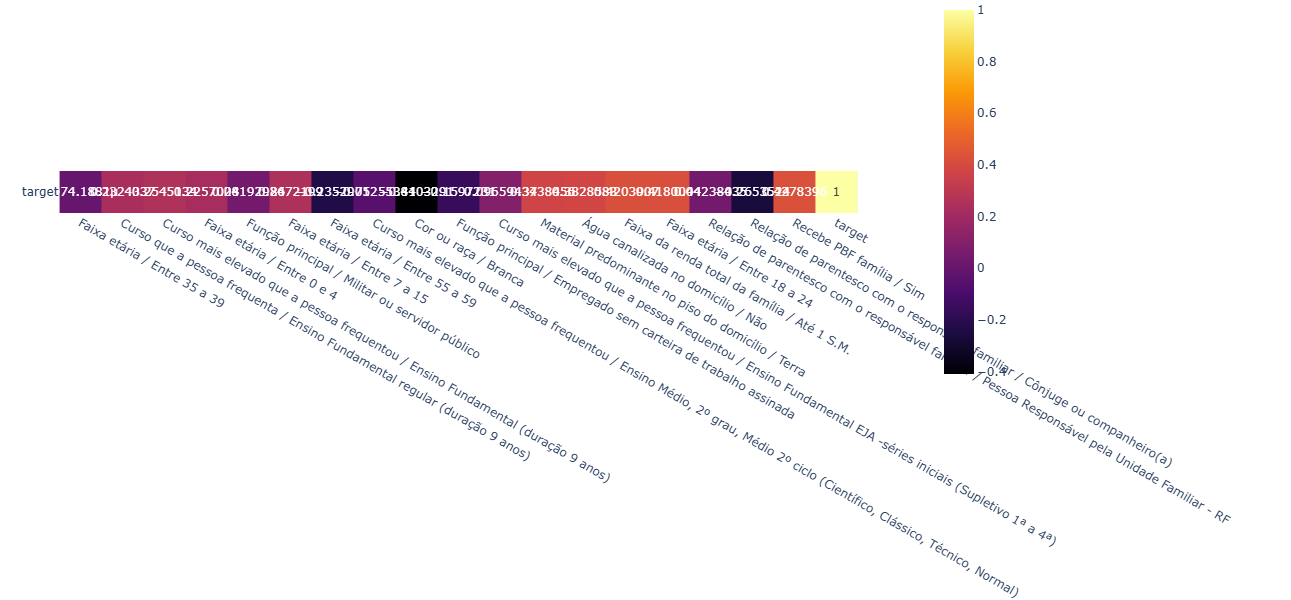

In [42]:
spear_corr = data.corr(method="spearman")
histogram_plot(spear_corr)

# 3. Predição

In [30]:
xgb = XGBRegressor(n_estimators=200, colsample_bylevel=0.25,
 learning_rate=0.025,
 max_depth=3,
 subsample=0.75
)


xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.25, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.025, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [31]:
y_pred = xgb.predict(x_test)

# 4. Gráficos

In [32]:
import plotly.graph_objects as go
# import geopandas as gpd

In [ ]:
geojs = gpd.read_file('/content/drive/MyDrive/Geographic analisys/data/geojs-23-mun.json')
geojs['y_pred'] = y_pred
geojs['y_test'] = list(y_test)

In [ ]:
geojs

In [ ]:
fig = px.choropleth_mapbox(geojs,
                           geojson=geojs.__geo_interface__,
                           locations=geojs.index,
                           color='y_test',
                           color_continuous_scale='Pinkyl',
                           mapbox_style='carto-positron',
                           zoom=6,
                           range_color=[0,25],
                           center = {"lat": -5.5, "lon": -43},
                           opacity=1.0,
                           labels={'y_test':'Real'})


#Remoção das margens
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# Show the map
fig.show()


fig = px.choropleth_mapbox(geojs,
                           geojson=geojs.__geo_interface__,
                           locations=geojs.index,
                           color='y_pred',
                           color_continuous_scale='Pinkyl',
                           mapbox_style='carto-positron',
                           zoom=6,
                           range_color=[0,25],
                           center = {"lat": -5.5, "lon": -43},
                           opacity=1.0,
                           labels={'y_pred':'Predito'})


#Remoção das margens
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# Show the map
fig.show()

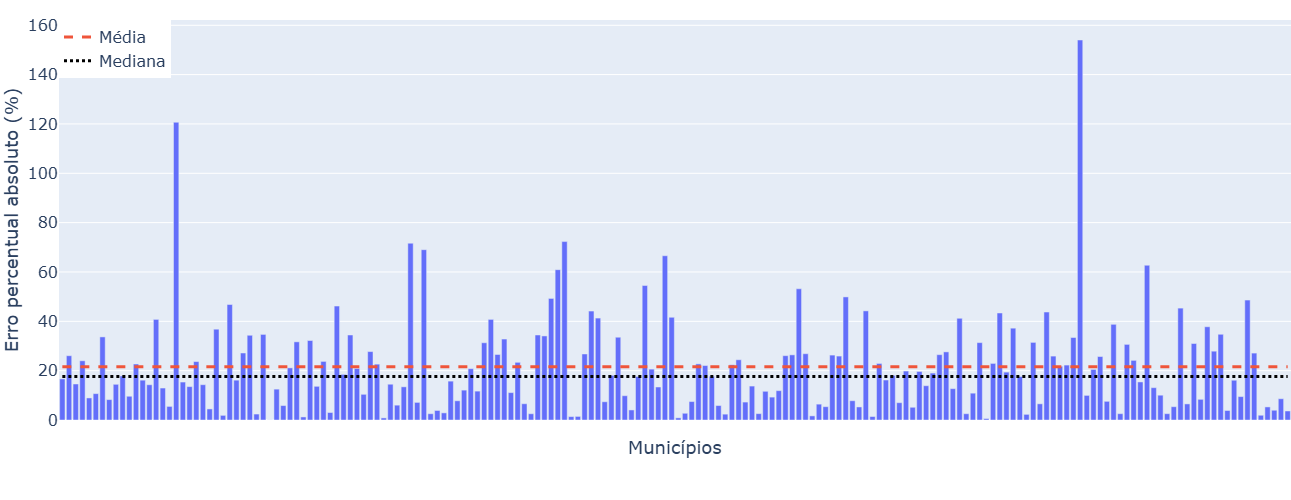

In [45]:

municipalities = list(df_test['Município'])
ape = np.abs((y_pred - y_test) / y_test) * 100
mean_ape   = ape.mean()
median_ape = np.median(ape)

COMMON_FONT   = 16   # tamanho base
TITLE_FONT    = 18   # um pouco maior p/ títulos

fig = go.Figure()

# Barras
fig.add_trace(go.Bar(
    x=municipalities,
    y=ape,
    showlegend=False,
    textposition='auto',
    textfont=dict(size=COMMON_FONT)   # textos sobre as barras
))

# Média (linha tracejada)
fig.add_trace(go.Scatter(
    name='Média',
    x=municipalities,
    y=[mean_ape]*len(municipalities),
    mode='lines',
    line=dict(dash='dash', width=3)
))

# Mediana (linha pontilhada)
fig.add_trace(go.Scatter(
    name='Mediana',
    x=municipalities,
    y=[median_ape]*len(municipalities),
    mode='lines',
    line=dict(dash='dot', color='black', width=3)
))

fig.update_layout(
    # fonte global
    font=dict(size=COMMON_FONT),

    # eixo y (título + valores)
    yaxis=dict(
        title='Erro percentual absoluto (%)',
        title_font=dict(size=TITLE_FONT),
        tickfont=dict(size=COMMON_FONT)
    ),

    # eixo x (sem ticks; título virá como anotação)
    xaxis=dict(showticklabels=False, title=None),

    legend=dict(
        font=dict(size=COMMON_FONT),
        yanchor="top", y=1.0,
        xanchor="left", x=0
    ),

    width=1200, height=500,
    margin=dict(l=0, r=0, t=20, b=80)
)

# Anotação-título “Municípios”
fig.add_annotation(
    text="Municípios",
    xref="paper", yref="paper",
    x=0.5, y=-0.10,
    showarrow=False,
    font=dict(size=TITLE_FONT)
)

fig.show()

In [47]:
print('Mediana: ', median_ape)

Mediana:  17.621615745255546


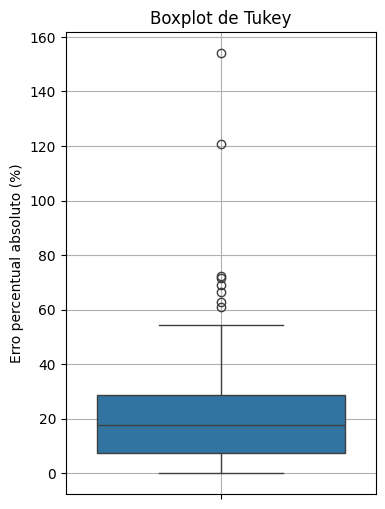

Número de outliers: 8
Porcentagem de outliers: 4.3478260869565215
Outliers encontrados: 1003    120.691050
1038     71.669604
1040     69.029048
1060     60.929438
1061     72.318389
1076     66.578251
1138    154.029320
1148     62.721538
Name: Peso/Altura < Escore-z -2 (%), dtype: float64


In [46]:
plt.figure(figsize=(4, 6))
sns.boxplot(data=ape, whis=1.5)  # Tukey uses 1.5 IQR to define outliers
plt.title("Boxplot de Tukey")
plt.ylabel('Erro percentual absoluto (%)')
plt.grid(True)
plt.show()

# Cálculo do IQR (Intervalo Interquartílico)
q1 = np.percentile(ape, 25)
q3 = np.percentile(ape, 75)
iqr = q3 - q1

# Limites para outliers segundo Tukey
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identificação dos outliers
outliers = ape[(ape < lower_bound) | (ape > upper_bound)]

print(f"Número de outliers: {len(outliers)}")
print(f"Porcentagem de outliers: {100*len(outliers)/len(ape)}")
print(f"Outliers encontrados: {outliers}")

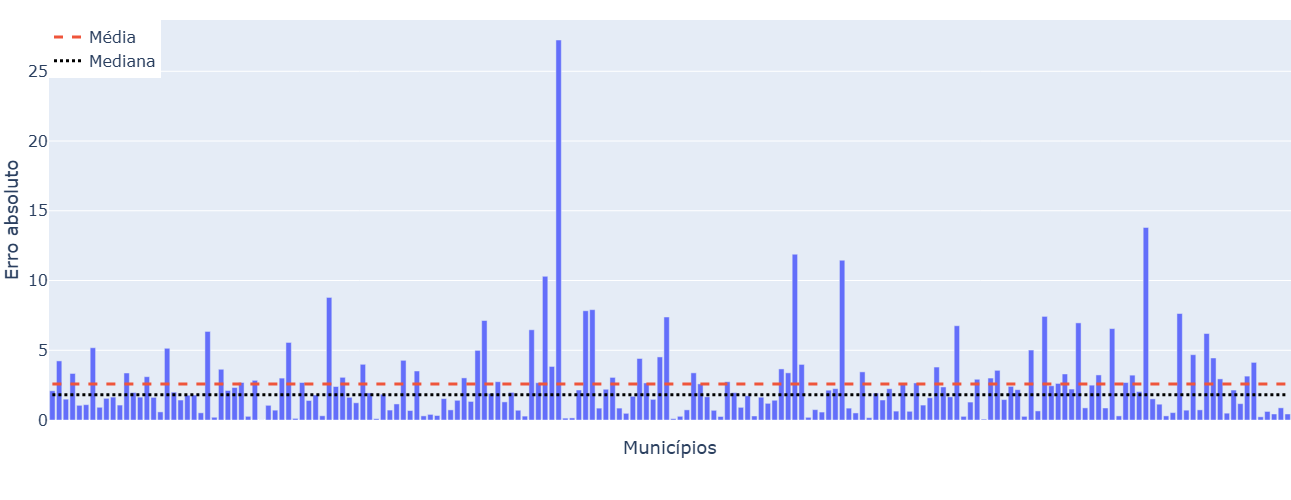

In [35]:

municipalities = list(df_test['Município'])
ape = np.abs(y_pred - y_test)
mean_ape   = ape.mean()
median_ape = np.median(ape)

COMMON_FONT   = 16   # tamanho base
TITLE_FONT    = 18   # um pouco maior p/ títulos

fig = go.Figure()

# Barras
fig.add_trace(go.Bar(
    x=municipalities,
    y=ape,
    showlegend=False,
    textposition='auto',
    textfont=dict(size=COMMON_FONT)   # textos sobre as barras
))

# Média (linha tracejada)
fig.add_trace(go.Scatter(
    name='Média',
    x=municipalities,
    y=[mean_ape]*len(municipalities),
    mode='lines',
    line=dict(dash='dash', width=3)
))

# Mediana (linha pontilhada)
fig.add_trace(go.Scatter(
    name='Mediana',
    x=municipalities,
    y=[median_ape]*len(municipalities),
    mode='lines',
    line=dict(dash='dot', color='black', width=3)
))

fig.update_layout(
    # fonte global
    font=dict(size=COMMON_FONT),

    # eixo y (título + valores)
    yaxis=dict(
        title='Erro absoluto',
        title_font=dict(size=TITLE_FONT),
        tickfont=dict(size=COMMON_FONT)
    ),

    # eixo x (sem ticks; título virá como anotação)
    xaxis=dict(showticklabels=False, title=None),

    legend=dict(
        font=dict(size=COMMON_FONT),
        yanchor="top", y=1.0,
        xanchor="left", x=0
    ),

    width=1200, height=500,
    margin=dict(l=0, r=0, t=20, b=80)
)

# Anotação-título “Municípios”
fig.add_annotation(
    text="Municípios",
    xref="paper", yref="paper",
    x=0.5, y=-0.10,
    showarrow=False,
    font=dict(size=TITLE_FONT)
)

fig.show()

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [37]:
print("RMSE: " + str(mean_squared_error(y_test, y_pred, squared=False)))
print("MAE: " + str(mean_absolute_error(y_test, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_test, y_pred)))
print("R2: " + str(r2_score(y_test, y_pred)))

RMSE: 3.928421204549758
MAE: 2.576242677439814
MAPE: 0.21536155458811326
R2: -0.0667353880098307


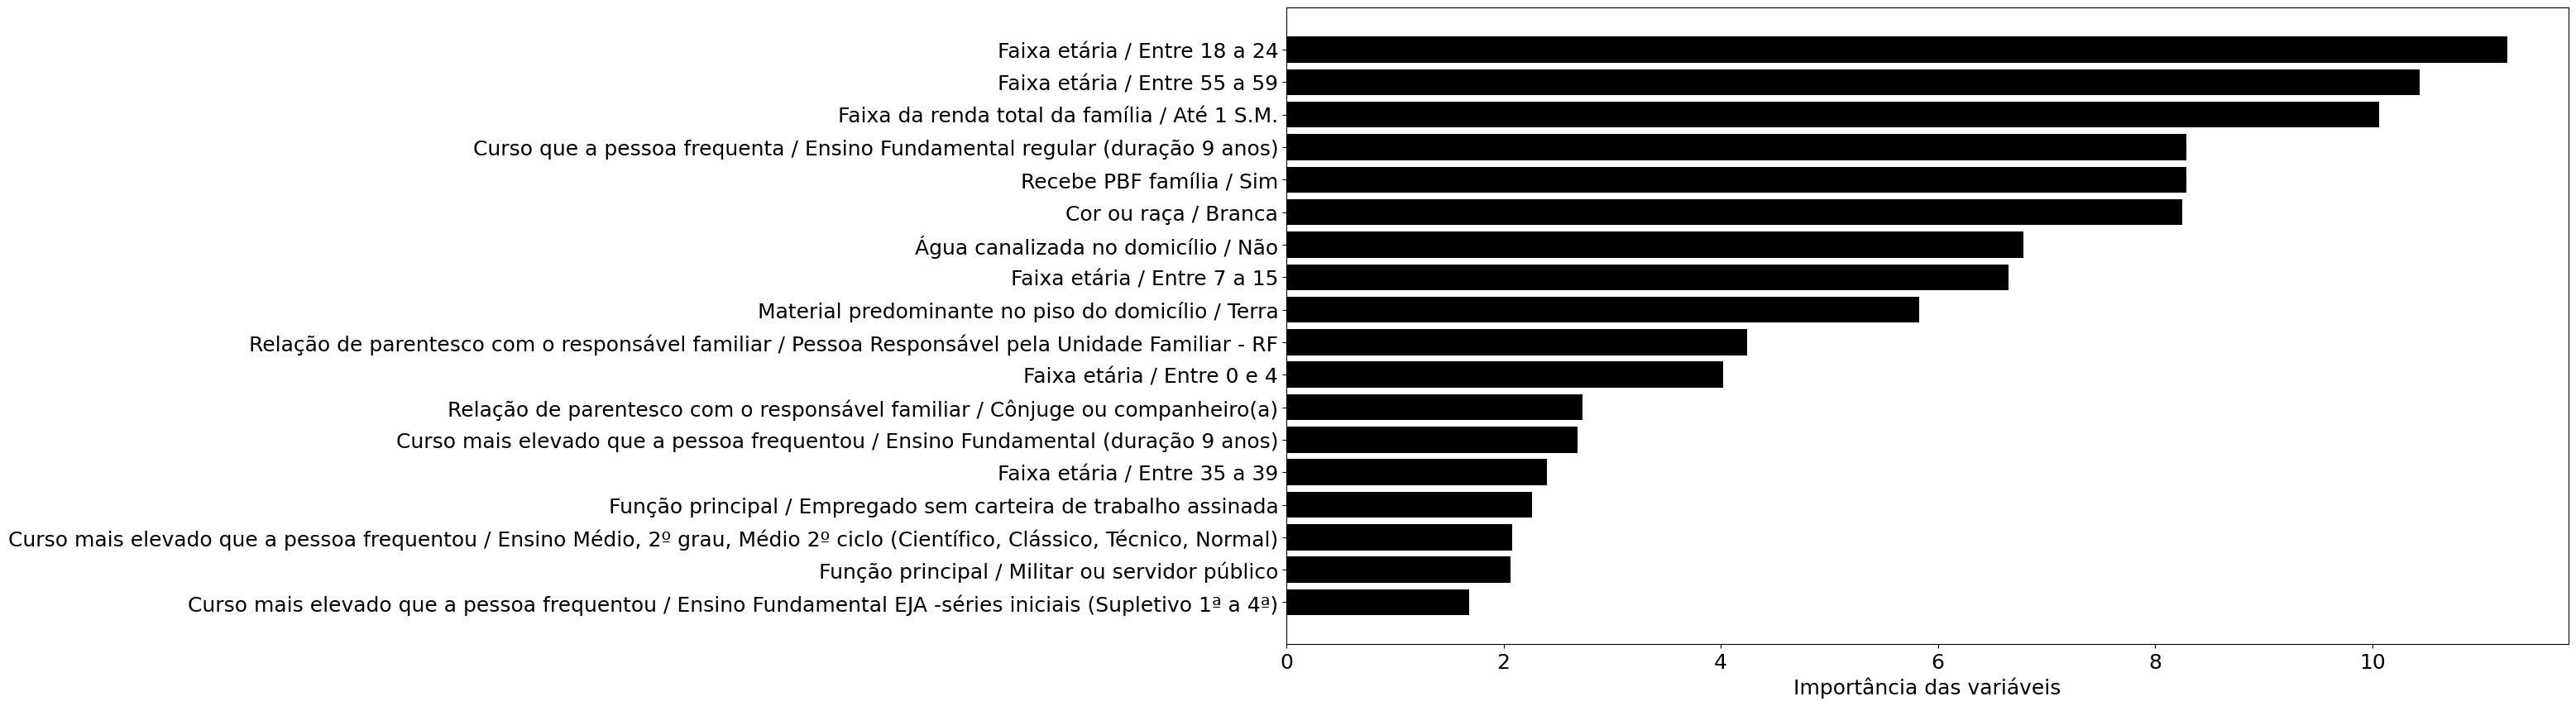

In [53]:
plt.rcParams["figure.figsize"] = (20,10)
sorted_feature_importance = xgb.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_feature_importance],
        100*xgb.feature_importances_[sorted_feature_importance],
        color='black')
plt.xlabel("Importância das variáveis", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)

In [51]:
x_train.columns[sorted_feature_importance]

Index(['Curso mais elevado que a pessoa frequentou / Ensino Fundamental EJA -séries iniciais (Supletivo 1ª a 4ª)',
       'Função principal / Militar ou servidor público',
       'Curso mais elevado que a pessoa frequentou / Ensino Médio, 2º grau, Médio 2º ciclo (Científico, Clássico, Técnico, Normal)',
       'Função principal / Empregado sem carteira de trabalho assinada',
       'Faixa etária / Entre 35 a 39',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental (duração 9 anos)',
       'Relação de parentesco com o responsável familiar / Cônjuge ou companheiro(a)',
       'Faixa etária / Entre 0 e 4',
       'Relação de parentesco com o responsável familiar / Pessoa Responsável pela Unidade Familiar - RF',
       'Material predominante no piso do domicílio / Terra',
       'Faixa etária / Entre 7 a 15', 'Água canalizada no domicílio / Não',
       'Cor ou raça / Branca', 'Recebe PBF família / Sim',
       'Curso que a pessoa frequenta / Ensino Fundamental regular

In [54]:
100*xgb.feature_importances_[sorted_feature_importance]

array([ 1.6851742,  2.0663023,  2.081644 ,  2.2644262,  2.396359 ,
        2.6797147,  2.724867 ,  4.0251894,  4.239867 ,  5.83072  ,
        6.6532383,  6.7877727,  8.246529 ,  8.284394 ,  8.290351 ,
       10.0652   , 10.433492 , 11.244759 ], dtype=float32)